In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import wfdb

# fixed random seed
np.random.seed(0)

from utils import computeCO, computeMAP, computeRR
from controlProblem import solveNOC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 - Load data

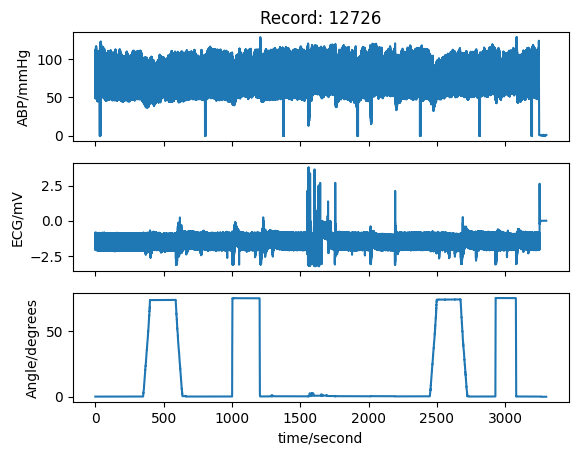

In [4]:
patientNum = 12726
dataDir = f"data/physionet.org/files/prcp/1.0.0/{patientNum}"
record = wfdb.rdrecord(dataDir)

wfdb.plot_wfdb(record)

In [5]:
fs = record.fs

bpRaw = record.p_signal[:,0]
tiltAngleRaw = record.p_signal[:,2]
time = np.arange(0, bpRaw.size) / fs

In [6]:
sex = record.comments[0].split(" ")[4]
height = float(record.comments[0].split(" ")[-4])
weight = float(record.comments[0].split(" ")[-1])
sex, height, weight

('M', 170.0, 64.0)

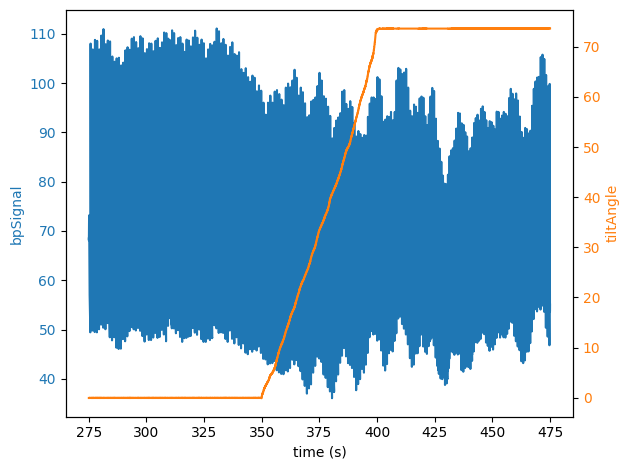

In [120]:
startTime = 275 # in seconds
endTime = 475 # in seconds

startIdx = startTime * fs
endIdx = endTime * fs

bpSignal = bpRaw[startIdx:endIdx]
tiltAngle = tiltAngleRaw[startIdx:endIdx]
timeWindow = time[startIdx:endIdx]

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('bpSignal', color=color)
ax1.plot(timeWindow, bpSignal, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('tiltAngle', color=color)  
ax2.plot(timeWindow, tiltAngle, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


(50000,) 250


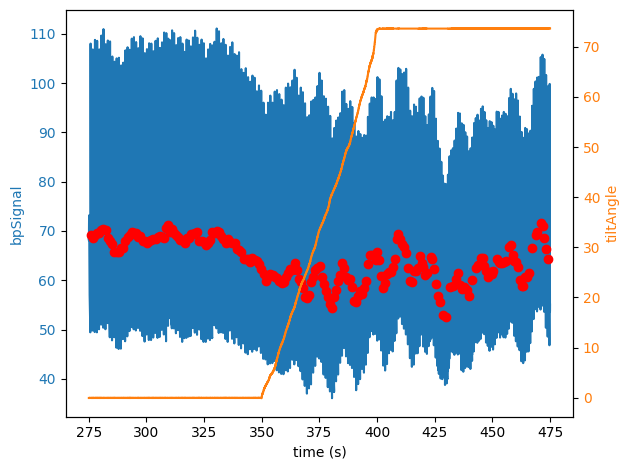

In [121]:
map, beatIdces = computeMAP(bpSignal, fs)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('bpSignal', color=color)
ax1.plot(timeWindow, bpSignal, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(timeWindow[beatIdces[:-1]], map, 'ro')
# ax1.plot(timeWindow[beatIdces], bpSignal[beatIdces], 'ro')

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('tiltAngle', color=color)  
ax2.plot(timeWindow, tiltAngle, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

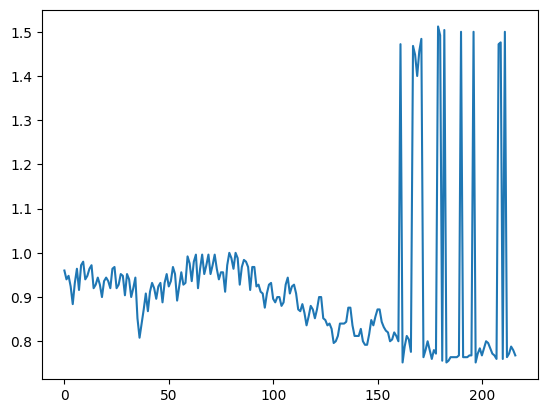

In [123]:
RRs = computeRR(beatIdces, fs)
plt.plot(RRs)

79 135


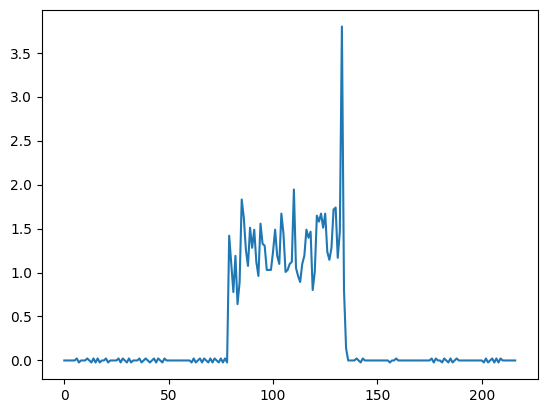

In [124]:
plt.plot(np.diff(tiltAngle[beatIdces]))
tiltIdces = np.diff(tiltAngle[beatIdces]) > 0.1
tiltStartIdx = np.where(tiltIdces)[0][0]
tiltEndIdx = np.where(tiltIdces)[0][-1]

print(tiltStartIdx, tiltEndIdx)

## 2 - Optimal control

In [126]:
# (Cau, Cal, Cvu, Cvl, Ral, Ralp, Rvl)
RCVals = (1.7, 0.26, 51, 4.3, 0.15, 7.1, 0.028)

#some other constants (Hoyean)
# u0_lb = 0.62
# u0_ub = 1.0
# u1_lb = 81
# u1_ub = 99
# x_init = np.zeros(4)

In [127]:
h = RRs

In [128]:
map.shape, h.shape

((217,), (217,))

In [129]:
Qd = computeCO(weight, height, sex)
x0, x1, x2, x3, u0, u1 = solveNOC(map, RCVals, Qd, h, tiltStartIdx, tiltEndIdx)

Iteration limit reached    (Exit mode 9)
            Current function value: 4.367140397699252
            Iterations: 50
            Function evaluations: 65110
            Gradient evaluations: 50
 message: Iteration limit reached
 success: False
  status: 9
     fun: 4.367140397699252
       x: [ 7.110e+01  7.100e+01 ...  7.566e+01  7.918e+01]
     nit: 50
     jac: [ 7.902e-04  1.019e-03 ... -1.371e-03 -2.728e-04]
    nfev: 65110
    njev: 50


# 3 - Visualize results

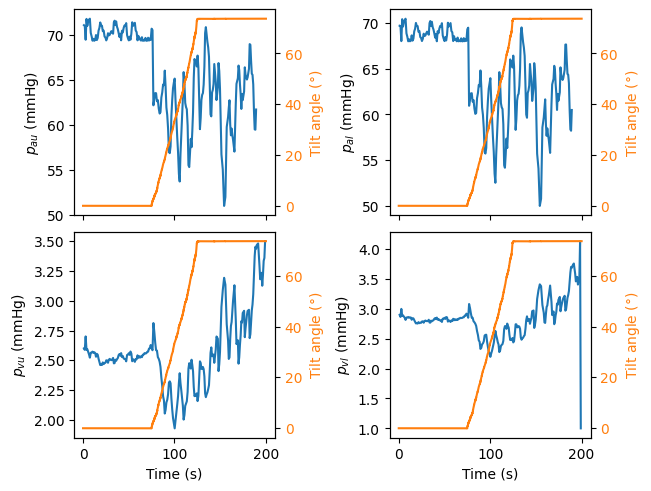

In [130]:
# PLOT STATES
x = np.vstack((x0, x1, x2, x3)).T
u = np.vstack((u0, u1)).T

# x = np.zeros((bpDownsample.size + 1, 4))
# u = np.zeros((bpDownsample.size, 2))

f, axs = plt.subplots(2, 2, sharex = True, constrained_layout=True)
timeStates = np.cumsum(h)

axs[0,0].plot(timeStates[:-10], x[:-10,0])
axs[0,0].set_ylabel('$p_{au}$ (mmHg)')

axs[0,1].plot(timeStates[:-10], x[:-10,1])
axs[0,1].set_ylabel('$p_{al}$ (mmHg)')

axs[1,0].plot(timeStates, x[:,2])
axs[1,0].set_ylabel('$p_{vu}$ (mmHg)')
axs[1,0].set_xlabel('Time (s)')

axs[1,1].plot(timeStates, x[:,3])
axs[1,1].set_ylabel('$p_{vl}$ (mmHg)')
axs[1,1].set_xlabel('Time (s)')

for i in range(2):
    for j in range(2):
        axTiltAngle = axs[i,j].twinx()
        axTiltAngle.plot(timeWindow-timeWindow[0], tiltAngle, color='tab:orange')
        axTiltAngle.set_ylabel('Tilt angle ($\degree$)', color='tab:orange')
        axTiltAngle.tick_params(axis='y', labelcolor='tab:orange')

plt.show()

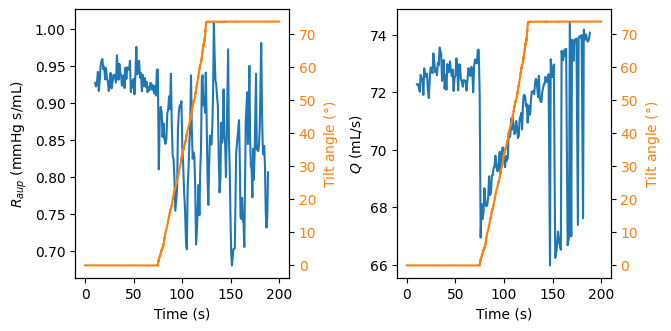

In [135]:
# PLOT CONTROLS

f, axs = plt.subplots(1, 2, figsize=(6.6, 3.2), sharex=True, constrained_layout=True)

axs[0].plot(timeStates[10:-11], u[10:-10,0])
axs[0].set_ylabel('$R_{aup}$ (mmHg s/mL)')
axs[0].set_xlabel('Time (s)')

axs[1].plot(timeStates[10:-11], u[10:-10,1])
axs[1].set_ylabel('$Q$ (mL/s)')
axs[1].set_xlabel('Time (s)')

for i in range(2):
    axTiltAngle = axs[i].twinx()
    axTiltAngle.plot(timeWindow-timeWindow[0], tiltAngle, color='tab:orange')
    axTiltAngle.set_ylabel('Tilt angle ($\degree$)', color='tab:orange')
    axTiltAngle.tick_params(axis='y', labelcolor='tab:orange')